In [ ]:
!pip install lightkurve
!pip install batman-package --update
!pip install batman-package
!pip install numpy --upgrade
!pip install pandas
!pip install lmfit


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --update


# **Planet B**

Mounted at /content/drive


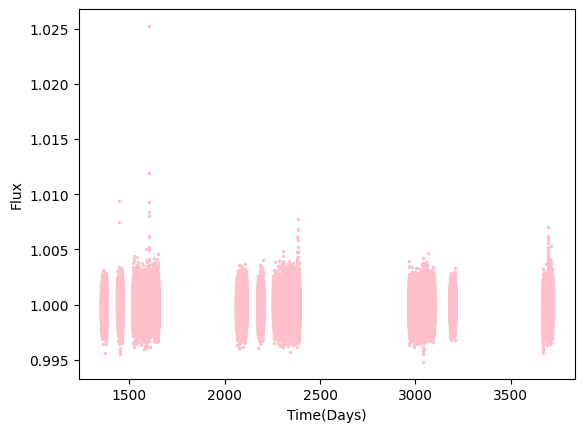

In [ ]:
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

search_result = lk.search_lightcurve('TIC 307210830',exptime = 120, author = 'SPOC')
lc_collection = search_result.download_all(quality_bitmask='hardest')
lcu = lc_collection.stitch().remove_nans()

new_flux = lcu.flux.value
new_flux = np.ma.filled(new_flux, fill_value=np.nan)
new_time = lcu.time.value
new_error = lcu.flux_err.value
new_error = np.ma.filled(new_error, fill_value=np.nan)


new_array = [new_time, new_flux, new_error]


np.savetxt('new_array.txt', np.column_stack((new_time, new_flux, new_error)), delimiter = ',', header = 'time,flux,flux_err', comments = '')

plt.scatter(new_time, new_flux, zorder = 10, color = 'pink', s = 2)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('TESS_Data_from_Data_values.png')
plt.show()


In [ ]:
import lmfit as lm
import batman
import numpy as np

from lmfit import fit_report
from lmfit import minimize, Parameters

from astropy import constants as const
from astropy import units as uu

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

period = np.linspace(1, 20, 10000)
bls = lcu.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

new_time, new_flux, new_error = np.genfromtxt('drive/MyDrive/Colab Notebooks/new_array.txt', unpack=True, delimiter=',')
nans = np.isnan(new_time) | np.isnan(new_flux) | np.isnan(new_error)
new_time, new_flux, new_error = new_time[~nans], new_flux[~nans], new_error[~nans]

paramslm = Parameters()
paramslm.add('t', value = 3.69066906690669 , vary = True, min = 3.68, max =3.70)
paramslm.add('m', value = 0.273 , vary = False)
paramslm.add('w', value = 261, vary = False)
paramslm.add('rpl',value = 1.4 , vary = True, min =1.3 , max = 1.6 )
paramslm.add('rs', value = 0.303, vary = False )
paramslm.add('inc', value =88.11 , vary = False )
paramslm.add('ecc', value =0.115, vary = True, min = 0.09, max = 0.12)
paramslm.add('t0', value = 1356.20231 , vary = True, min = 1356.2, max = 1356.21)

#t0=vary,
def keplers_3rd_law(m,t):
    time = t*86400
    mass = m*1.989*10**30
    g = 6.67430*10**(-11)
    a = ((time**2)*g*mass)/(4*(np.pi**2))
    return a**(1/3)/(0.3*6.96*(10**8))

def rp_ratio(rpl,rs):
    return ((rpl*6378)/(rs*6.96*(10**5)))

def model_function(paramslm, new_time, error, data = None):
  vals = paramslm.valuesdict()
  t = vals['t']
  m = vals['m']
  w = vals['w']
  rpl = vals['rpl']
  rs = vals['rs']
  inc = vals['inc']
  ecc = vals['ecc']
  t0 = vals['t0']
 # frac_rp = vals['frac_rp']

  ax = keplers_3rd_law(m = m , t = t )
  rp = rp_ratio(rpl = rpl ,rs = rs )

#batman package starts here:


  params = batman.TransitParams()       #object to store transit parameters
  params.t0 = t0                        #time of inferior conjunction
  params.per = t                      #orbital period
  params.rp = rp                      #planet radius (in units of stellar radii)
  params.a = ax                       #semi-major axis (in units of stellar radii)
  params.inc = inc                     #orbital inclination (in degrees)
  params.ecc = ecc                     #eccentricity
  params.w = 261.                        #longitude of periastron (in degrees)
  params.limb_dark = "quadratic"        #limb darkening model
  params.u = [0.65,-0.11]

  model = batman.TransitModel(params, new_time)

  m_flux = model.light_curve(params)

  if data is None:
        return m_flux
  else:
        return m_flux-data




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:

m_flux = model_function(paramslm, new_time, new_error)
plt.plot(new_time, m_flux, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(2175,2185)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('3_Transits_of_Planet_C.png')
plt.show()

m_flux = model_function(paramslm, new_time, new_error)
plt.plot(new_time, m_flux, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(2179,2179.5)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('1_Transit_of_Planet_C_Zoomed_in.png')
plt.show()

In [ ]:
out = minimize(model_function, paramslm, args=(new_time, new_error), kws={'data': new_flux}, nan_policy='omit')
print(fit_report(out))


In [ ]:
planet_b_model = lk.LightCurve( time=new_time, flux = new_flux,flux_err=new_error)
planet_b_model.fold(period = out.params['t'].value, t0 = out.params['t0'].value ).scatter(c='pink', lw=1)
plt.xlim(-0.3,0.3)
plt.ylim(0.994,1.008)
plt.savefig('Planet_C_Fold.png')


In [ ]:

min_light_curveb = model_function(out.params, new_time, new_error)

plt.plot(new_time, min_light_curveb, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
#plt.xlim(1510,1530)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.show()

plt.plot(new_time, min_light_curveb, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(1518,1527)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('Planet_C_Lightcurve_Data_with_final_params_and_masked_data.png')
plt.show()



lcu_new = lk.LightCurve( time=new_time, flux = new_flux,flux_err=new_error)
bin_lcu = lcu_new.bin(binsize = 10)
bin_lcu.fold(period = out.params['t'].value, t0 = out.params['t0'].value ).scatter(c='pink', lw=1)
plt.xlim(-0.3,0.3)
plt.ylim(0.994,1.002)



bin_lcu.scatter(color = 'pink')
plt.ylim(0.995,1.005)
plt.xlim(1643,1653)
#plt.savefig('Planet_C_Binned_Data.png')
plt.show()

bin_lcu.scatter(color = 'pink')
plt.plot(new_time,min_light_curveb , zorder = 10, color = 'crimson')
plt.ylim(0.995,1.005)
plt.xlim(1643,1653)
#plt.savefig('Planet_C_Binned_Transit.png')
plt.show()

In [ ]:
sorted = np.argsort(new_time)
new_time = new_time[sorted]
new_flux = new_flux[sorted]
new_error = new_error[sorted]

masked_fluxb = new_flux / min_light_curveb
masked_timeb = new_time / min_light_curveb
masked_errorb = new_error / min_light_curveb



lcu_new_masked = lk.LightCurve( time=masked_timeb, flux = masked_fluxb,flux_err=masked_errorb)
bin_lcu = lcu_new_masked.bin(binsize = 10)

plt.scatter(masked_timeb, masked_fluxb, zorder = 10, color = 'plum', s = 2)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('Planet_D_Lighcurve_Data_after_masking.png')
plt.show()




In [ ]:
bin_lcu.scatter(color = 'darkmagenta')
#plt.xlim(1643,1648)
plt.xlabel('Time(Days)')
plt.show()

# **Planet C**

In [ ]:
from lmfit import minimize

sorted = np.argsort(new_time)
new_time = new_time[sorted]
new_flux = new_flux[sorted]
new_error = new_error[sorted]

masked_fluxb = new_flux / min_light_curveb
masked_timeb = new_time / min_light_curveb
masked_errorb = new_error / min_light_curveb

sorter_new = np.argsort(masked_timeb)
masked_timeb = masked_timeb[sorter_new]
masked_fluxb = masked_fluxb[sorter_new]
masked_errorb = masked_errorb[sorter_new]

In [ ]:
import lmfit as lm
import batman
import numpy as np

from lmfit import fit_report
from lmfit import minimize, Parameters

from astropy import constants as const
from astropy import units as uu

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

period = np.linspace(1, 20, 10000)
bls = lcu.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power

new_time, new_flux, new_error = np.genfromtxt('drive/MyDrive/Colab Notebooks/new_array.txt', unpack=True, delimiter=',')
nans = np.isnan(new_time) | np.isnan(new_flux) | np.isnan(new_error)
new_time, new_flux, new_error = new_time[~nans], new_flux[~nans], new_error[~nans]

paramslm = Parameters()
paramslm.add('t', value = 7.45094 , vary = True, min = 7.44, max =7.46)
paramslm.add('m', value = 0.273 , vary = False)
paramslm.add('w', value = 180, vary = False)
paramslm.add('rpl',value = 1.515, vary = True, min =1.4 , max = 1.6)
paramslm.add('rs', value = 0.303, vary = False )
paramslm.add('inc', value =88.449 , vary = False )
paramslm.add('ecc', value =0.085, vary = True, min = 0.065, max = 0.095)
paramslm.add('t0', value = 1355.2574113410246, vary = True, min = 1352, max = 1358)

#t0=vary,
def keplers_3rd_law(m,t):
    time = t*86400
    mass = m*1.989*10**30
    g = 6.67430*10**(-11)
    a = ((time**2)*g*mass)/(4*(np.pi**2))
    return a**(1/3)/(0.3*6.96*(10**8))

def rp_ratio(rpl,rs):
    return ((rpl*6378)/(rs*6.96*(10**5)))

def model_functionc(paramslm, masked_timeb, masked_errorb, data = None):
  vals = paramslm.valuesdict()
  t = vals['t']
  m = vals['m']
  w = vals['w']
  rpl = vals['rpl']
  rs = vals['rs']
  inc = vals['inc']
  ecc = vals['ecc']
  t0 = vals['t0']
 # frac_rp = vals['frac_rp']

  ax = keplers_3rd_law(m = m , t = t )
  rp = rp_ratio(rpl = rpl ,rs = rs )

#batman package starts here:


  params = batman.TransitParams()       #object to store transit parameters
  params.t0 = t0                        #time of inferior conjunction
  params.per = t                      #orbital period
  params.rp = rp                      #planet radius (in units of stellar radii)
  params.a = ax                       #semi-major axis (in units of stellar radii)
  params.inc = inc                     #orbital inclination (in degrees)
  params.ecc = ecc                     #eccentricity
  params.w = 180.                        #longitude of periastron (in degrees)
  params.limb_dark = "quadratic"        #limb darkening model
  params.u = [0.65,-0.11]

  model = batman.TransitModel(params, masked_timeb)

  m_flux = model.light_curve(params)

  if data is None:
        return m_flux
  else:
        return m_flux-data



In [ ]:
m_flux = model_functionc(paramslm, masked_timeb, masked_errorb)
plt.plot(masked_timeb, m_flux, color= 'darkmagenta')
plt.scatter(masked_timeb, masked_fluxb,color = 'plum', marker = '.', s = 4)
plt.xlim(2189.5,2190)
plt.ylim(0.995,1.004)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('1_Transit_of_Planet_D.png')
plt.show()

m_flux = model_functionc(paramslm, masked_timeb, masked_errorb)
plt.plot(masked_timeb, m_flux, color= 'darkmagenta')
plt.scatter(masked_timeb, masked_fluxb,color = 'plum', marker = '.', s = 7)
plt.xlim(2174,2200)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('4_Transits_of_Planet_D.png')
plt.show()

In [ ]:
out1 = minimize(model_functionc, paramslm, args=(masked_timeb, masked_errorb), kws={'data': masked_fluxb}, nan_policy='omit')
print(fit_report(out))

In [ ]:
planet_c_model = lk.LightCurve(time=masked_timeb, flux = masked_fluxb,flux_err=masked_errorb)
planet_c_model.fold(period = out1.params['t'].value, t0 = out1.params['t0'].value).scatter(c='plum', lw=1)
plt.ylim(0.995, 1.005)
plt.xlim(-1, 1)
plt.savefig('Planet_D_Fold.png')


In [ ]:

min_light_curvec = model_functionc(out1.params, masked_timeb, masked_errorb)
plt.plot(masked_timeb, min_light_curvec, color= 'darkmagenta')
plt.scatter(masked_timeb, masked_fluxb,color = 'plum', marker = '.', s = 4)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('Planet_D_Lightcurve_Data_with_final_params_and_masked_data.png')
plt.show()


lcu_new = lk.LightCurve( time=masked_timeb, flux = masked_fluxb,flux_err=masked_errorb)
bin_lcu = lcu_new.bin(binsize = 10)
bin_lcu.fold(period = out1.params['t'].value, t0 = out1.params['t0'].value ).scatter(c='plum', lw=1)

bin_lcu.scatter(color = 'plum')
plt.xlim(2061,2070)
plt.savefig('Planet_D_Binned_Data.png')
plt.show()

bin_lcu.scatter(color = 'plum')
plt.plot(masked_timeb,min_light_curvec , zorder = 10, color = 'darkmagenta')
plt.ylim(0.995,1.002)
plt.xlim(1643,1648)
plt.xlabel('Time(Days)')
plt.savefig('Planet_D_Binned_Transit.png')
plt.show()

# **Planet D**

In [ ]:
sorter_new = np.argsort(masked_timeb)
masked_timeb = masked_timeb[sorter_new]
masked_fluxb = masked_fluxb[sorter_new]
masked_errorb = masked_errorb[sorter_new]


masked_fluxc = masked_fluxb / min_light_curvec
masked_timec = masked_timeb / min_light_curvec
masked_errorc = masked_errorb / min_light_curvec

sorted_new = np.argsort(masked_timec)
masked_timec = masked_timec[sorted_new]
masked_fluxc = masked_fluxc[sorted_new]
masked_errorc = masked_errorc[sorted_new]

In [ ]:
import lmfit as lm
import batman
import numpy as np

from lmfit import fit_report
from lmfit import minimize, Parameters

from astropy import constants as const
from astropy import units as uu

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

period = np.linspace(1, 20, 10000)
bls = lcu.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_d_period = bls.period_at_max_power
planet_d_t0 = bls.transit_time_at_max_power
planet_d_dur = bls.duration_at_max_power

new_time, new_flux, new_error = np.genfromtxt('drive/MyDrive/Colab Notebooks/new_array.txt', unpack=True, delimiter=',')
nans = np.isnan(new_time) | np.isnan(new_flux) | np.isnan(new_error)
new_time, new_flux, new_error = new_time[~nans], new_flux[~nans], new_error[~nans]

paramslm = Parameters()
paramslm.add('t', value = 2.253125312531253 , vary = True, min = 2.24, max =2.26)
paramslm.add('m', value = 0.273 , vary = False)
paramslm.add('w', value = 192, vary = False)
paramslm.add('rpl',value = 1, vary = True, min =0.75 , max = 1.2)
paramslm.add('rs', value = 0.303, vary = False )
paramslm.add('inc', value =88.449 , vary = False )
paramslm.add('ecc', value =0.9, vary = True, min = 0.8, max = 1.1)
paramslm.add('t0', value = 1354.8974113410245, vary = True, min = 1353, max = 1356)

#t0=vary,
def keplers_3rd_law(m,t):
    time = t*86400
    mass = m*1.989*10**30
    g = 6.67430*10**(-11)
    a = ((time**2)*g*mass)/(4*(np.pi**2))
    return a**(1/3)/(0.3*6.96*(10**8))

def rp_ratio(rpl,rs):
    return ((rpl*6378)/(rs*6.96*(10**5)))

def model_functiond(paramslm, masked_timec, masked_errorc, data = None):
  vals = paramslm.valuesdict()
  t = vals['t']
  m = vals['m']
  w = vals['w']
  rpl = vals['rpl']
  rs = vals['rs']
  inc = vals['inc']
  ecc = vals['ecc']
  t0 = vals['t0']
 # frac_rp = vals['frac_rp']

  ax = keplers_3rd_law(m = m , t = t )
  rp = rp_ratio(rpl = rpl ,rs = rs )

#batman package starts here:


  params = batman.TransitParams()       #object to store transit parameters
  params.t0 = t0                        #time of inferior conjunction
  params.per = t                      #orbital period
  params.rp = rp                      #planet radius (in units of stellar radii)
  params.a = ax                       #semi-major axis (in units of stellar radii)
  params.inc = inc                     #orbital inclination (in degrees)
  params.ecc = ecc                     #eccentricity
  params.w = 192.                        #longitude of periastron (in degrees)
  params.limb_dark = "quadratic"        #limb darkening model
  params.u = [0.65,-0.11]

  model = batman.TransitModel(params, masked_timeb)

  m_flux = model.light_curve(params)

  if data is None:
        return m_flux
  else:
        return m_flux-data



In [ ]:
m_flux = model_functiond(paramslm, masked_timec, masked_errorc)
plt.plot(masked_timec, m_flux, color= 'teal')
plt.scatter(masked_timec, masked_fluxc,color = 'lightblue', marker = '.', s = 4)
plt.xlim(2064,2070)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('2_Transit_of_Planet_B_Zoomed_in.png')
plt.show()


m_flux = model_functiond(paramslm, masked_timec, masked_errorc)
plt.plot(masked_timec, m_flux, color= 'teal')
plt.scatter(masked_timec, masked_fluxc,color = 'lightblue', marker = '.', s = 7)
plt.xlim(2068,2070)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('1_Transits_of_Planet_B.png')
plt.show()

In [ ]:
out2 = minimize(model_functiond, paramslm, args=(masked_timec, masked_errorc), kws={'data': masked_fluxc}, nan_policy='omit')
print(fit_report(out))

In [ ]:
planet_d_model = lk.LightCurve(time=masked_timec, flux = masked_fluxc,flux_err=masked_errorc)
planet_d_model.fold(period = out2.params['t'].value, t0 = out2.params['t0'].value).scatter(c='lightblue', lw=1)
plt.ylim(0.995,1.005)
plt.savefig('Planet_B_LightCurve.png')

In [ ]:

min_light_curved = model_functiond(out2.params, masked_timec, masked_errorc)
plt.plot(masked_timec, min_light_curved, color= 'teal')
plt.scatter(masked_timec, masked_fluxc,color = 'lightblue', marker = '.', s = 4)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.ylim(0.996,1.004)
plt.xlim(1600,1610)
plt.show()

lcu_new1 = lk.LightCurve(time=masked_timec, flux = masked_fluxc,flux_err=masked_errorc)
bin_lcu2 = lcu_new1.bin(binsize = 10)
bin_lcu2.fold(period = out2.params['t'].value, t0 = out2.params['t0'].value ).scatter(c='lightblue', lw=1)

bin_lcu2.scatter(color = 'teal')
plt.xlim(2060,2070)
plt.savefig('Binned_Planet_B_Data.png')
plt.show()

bin_lcu2.scatter(color = 'lightblue')
plt.plot(masked_timec,min_light_curved , zorder = 10, color = 'teal')
plt.ylim(0.996,1.004)
plt.xlim(1600,1605)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.savefig('Planet_B_over_Binned_Data.png')
plt.show()

In [ ]:
import numpy as np


def equilibrium_temp(a):
  T_star = 3415
  R = 0.273
  Ab = 0
  EqT = (T_star)*((R/(2*a))**0.5)*((1-Ab)**(1/4))
  return EqT

print(f"The Equilibrium Temperature of L 98-59b is {equilibrium_temp(a = 0.021749504719453035)}K")
print(f"The Equilibrium Temperature of L 98-59c is {equilibrium_temp(a = 5.16469980055693)}K")
print(f"The Equilibrium Temperature of L 98-59d is {equilibrium_temp(a = 34.7030288888568)}K")

In [ ]:
import numpy as np

def R(rp):
  re = 1
  R = np.log10(rp/re)
  return R

#R_C = 1.47058905
#R_D = 1.55454226
#R_B = 0.80000371

print(f"The estimated radius for L 98-59b is {R(0.80000371)}")
print(f"The estimated radius for L 98-59c is {R(1.47058905)}")
print(f"The estimated radius for L 98-59d is {R(1.55454226)}")

In [ ]:
import numpy as np

def planet_m(R,C,S):
  M = (R-C)/S
  return 10**M



print(f"The mass for L 98-59b is {planet_m(R(0.80000371), 0.00346, 0.2790)}")
print(f"The mass for L 98-59c is {planet_m(R(1.47058905), -0.0925, 0.589 )}")
print(f"The mass for L 98-59d is {planet_m(R(1.55454226), -0.0925, 0.589 )}")

In [ ]:
import numpy as np

def planet_p(M,R):
  p = (3*M)/(4*(np.pi)*(R**3))
  return p

planet_cp = planet_p(M = planet_m(R(1.47058905), -0.0925, 0.589), R = R(1.47058905))
planet_dp = planet_p(M = planet_m(R(1.55454226), -0.0925, 0.589 ), R = R(1.55454226))
planet_bp = planet_p(M = planet_m(R(0.80000371), 0.00346, 0.2790), R = R(0.80000371))

print(f"The density for L 98-59b is {planet_bp}")
print(f"The density for L 98-59c is {planet_cp}")
print(f"The density for L 98-59d is {planet_dp}")

In [ ]:
import numpy as np

def S_effective(T_eff):
  S_sun = 1.0385
  T = T_eff - 5780
  a = 1.3242*(10**(-4))
  b = 1.5418*(10**(-8))
  c = (-7.9895)*(10**(-12))
  d = (-1.8328)*(10**(-15))

  S_eff = S_sun + (a*T) + (b*(T**2)) + (c*(T**3)) + (d*(T**4))
  return S_eff

def S_effective1(T_eff):
  S_sun = 0.3438
  T = T_eff - 5780
  a = 5.8942*(10**(-5))
  b = 1.6558*(10**(-9))
  c = (-3.0045)*(10**(-12))
  d = (-5.2983)*(10**(-16))

  S_eff1 = S_sun + (a*T) + (b*(T**2)) + (c*(T**3)) + (d*(T**4))
  return S_eff1

def d(S_eff):
  L_sun = 3.846e268
  L_star= 0.01128*(L_sun)
  d = ((L_star/L_sun)/S_eff)**0.5
  return d   #*(1.496*(10**11)) to convert from AU to meters
print(f"The Lower-Habitable Zone estimate for L 98-59 is {(d(S_effective(3415)))}AU")

def d(S_eff1):
  L_sun = 3.846e26
  L_star= 0.01128*(L_sun)
  d = ((L_star/L_sun)/S_eff1)**0.5
  return d   #*(1.496*(10**11)) to convert from AU to meters
print(f"The Upper-Habitable Zone estimate for L 98-59 is {(d(S_effective1(3415)))}AU")

#**Week 8 Summary**
---
---
#**Date: 10/03/2025**

---

**Things to do:**

* Get to defining the function for the density of our planets

* Define the function to find equilibrium temperature for all our planets too.

* Define the effective temperature and then habitable zone of our star.

* Work out errors on our planets on all our values

---
**Things done:**

* Defined functions for eqilubrium temp, planet mass, planet radius and planet density.

* Have values for all of those apart from equilibrium temp as my semi major axis keeps saying it isn't defined so for ease I will just work them out rather than spend hours finding the necessary code to work it out.

* Found effective temperature equation and now just trying to compute the effective temperture of our panet so then we can find the habitable zone of it.
---
**Papers and Resources:**

* https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag=1&constraint=disc_facility+like+%27%25TESS%25%27

* https://exoplanetarchive.ipac.caltech.edu/docs/pscp_calc.html

* https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/pdf

* https://www.cambridge.org/core/services/aop-cambridge-core/content/view/B3E54253A359289567E008E428E8770A/9781108419772c6_153-328.pdf/transits.pdf

---

**What next?:**

* My effective temperature is different to Jasmins so I want to get that sorted before I move onto anything else.

* I want to get my habitable zone found,finished and done.

* Work out all my errors and compare all values against papers that have known values.

---
---
#**Date: 13/03/2025**
---
**Things to do:**

* Work out errors on our mass parameter for density and then errors on the density using the mass error

* Get a graph showing the habitable zone of our star in comparison to our planets.

* Then show how our planet densities compare to outher planets.

* Re-make our graphs to make them look professional for our final report.

---
**Things done:**

* Debugging of values such as mass value and then density.

* input code for errors on mass and density

---
**Papers and Resources:**

* As above

---
---
